### Test the trained network

- Full network with VAE instead of AE

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard
from keras import optimizers
from keras import backend as K

from keras.regularizers import l2


import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

/home/gabrielle/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Network to load

In [2]:
timestamp = "2018-07-28_09:44"
batch_size = 1024

- Plot loss history

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [4]:
def plotHistory(loss_array, save=False, savename=timestamp+"-lossGraph.png"):
    fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax.set_title("Loss graph for end-to-end training")

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.plot(loss_array)
    
    if save:
        plt.savefig(savename)

In [5]:
filename = timestamp + "_history.npz"
with np.load(filename) as data:
    history = data["history_loss"]


history_epoch=[] ## avrg histories over all epochs

d=history.ravel()[0]   ##get the dictionary

for key in d.keys():
    if key.find("avg") > 0:  ## if the key contains "avg", add it to history_epoch
        history_epoch.append(d[key])

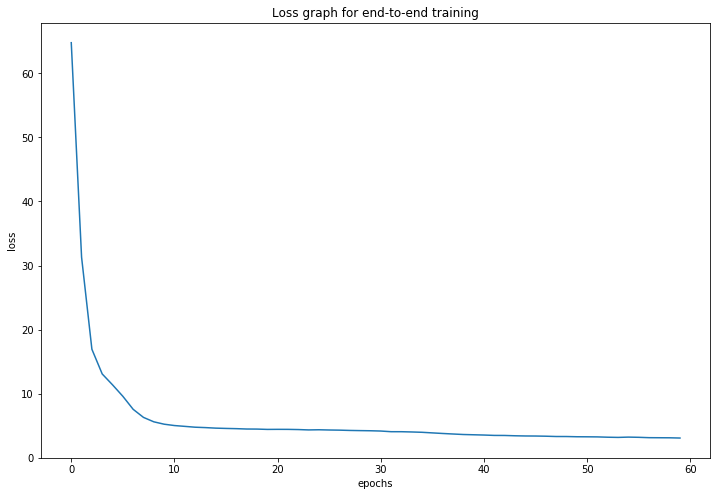

In [6]:
plotHistory(history_epoch, save=True)

- Network definition for testing

In [7]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [8]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, 
                 transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, 
                 batch_size=100,
                 gmm_mixtures=4,  ###default for the kdd99, from paper
                 lambda_1 = 0.1,
                 lambda_2 = 0.005,
                ):
        
        
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.gmm_mixtures = gmm_mixtures
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        
        ### init gmm parameters
        self.phi, self.mu, self.sigma = self._init_gmm()
        
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        ###self._create_loss_optimizer()
        self._total_loss()  ### new one
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
        
        ## cosine similarity
        self.cossim = self._layer_cossim(self.x, self.x_reconstr_mean)
        
        ## relative euc similarity
        self.relative_euc = self._layer_relative_eucdist(self.x, self.x_reconstr_mean)
        
        ## concat layers (z in original paper)
        self.concat = self._layer_concat(self.z, self.cossim, self.relative_euc)
        
        
        ##### estimation net
        input_est = self.concat 
        
        est_layer = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_est)   ####(input_est)
        est_layer = Dropout(0.5)(est_layer)
        self.est_output = Dense(self.gmm_mixtures, activation='softmax', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='gamma')(est_layer)

        
    def _layer_cossim(self, input_layer, output_layer):
        '''
        a: batch x 120
        b: batch x 120 

        output: batch x 1
        '''
        a, b = input_layer, output_layer  #a_b
    
        norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
        norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
        out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
        out = K.reshape(out, [self.batch_size, 1])
        
        return out
        
        
    def _layer_relative_eucdist(self, input_layer, output_layer):
        '''
        a: batch x 120
        b: batch x 120 

        output: batch x 1
        '''
        a, b = input_layer, output_layer  #a_b

        norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
        norm_a = K.sqrt(K.sum(a ** 2, axis=-1))

        out = norm_diff / norm_a
        out = K.reshape(out, [self.batch_size, 1])

        return out
        
        
    def _layer_concat(self, lowdim, cossim, relative_euc):
        return K.concatenate([lowdim, cossim, relative_euc])
    
    
    def _init_gmm(self):
        k = self.gmm_mixtures
        self.d = d = int(self.concat.get_shape()[1])
        
        phi = tf.get_variable("phi",
                      shape=(k),
                      dtype=tf.float32,
                      initializer=tf.zeros_initializer(),
                      trainable=False)

        mu = tf.get_variable("mu",
                              shape=(k,d),
                              dtype=tf.float32,
                              initializer=tf.zeros_initializer(), 
                              trainable=False)

        sigma_init = np.repeat([np.eye(d, dtype=np.float32)], k, axis=0)

        sigma = tf.get_variable("sigma",
                              shape=(k,d,d),
                              dtype=tf.float32,
                              initializer=tf.constant_initializer(sigma_init),
                              trainable=False)
        
        return (phi, mu, sigma)
        
    
    def _compute_energy(self, z_i):
        """
        compute E(z_i) in loss function
        """

        #inside_sum = 0
        inside_sum = tf.zeros(()) 
        for cluster in range(self.gmm_mixtures):
            diff = tf.reshape(z_i - self.mu[cluster], (1,-1))   ### (1,3)
            diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

            sigma_inv = tf.linalg.inv(self.sigma[cluster]) ### (3,3)

            exp_term = tf.exp(-0.5 * tf.matmul(diff, tf.matmul(sigma_inv, diff_t)))    ### (1,1)

            denom = tf.sqrt(tf.linalg.det(2 * np.pi * self.sigma[cluster]))

            inside_sum += self.phi[cluster] * (exp_term / denom)   ### (1,1)


        inside_sum = tf.reshape(inside_sum, ())
        sample_energy = -tf.log(inside_sum + 1e-6, name="sample_energy")

        ### flatten inside_sum and return log of it
        return sample_energy
    
    
    def save_weights(self, filename = "./" + timestamp + "-tfsave"):  
        ### save model weights
        saver = tf.train.Saver()
        saver.save(self.sess, filename)
        print("saved to:",filename)
        
        
        
    def load_weights(self, filename = "./" + timestamp + "-tfsave.meta"):
        ### load weights for test notebook
        saver = tf.train.import_meta_graph(filename)
        saver.restore(self.sess, tf.train.latest_checkpoint("./"))
    
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean

        
    def _update_gmm(self):
        gamma = self.est_output ### output of estimation net (batch size x 4)
        z = self.concat ### concat output (batch size x 3)
        
        
        ### get parameters
        self.updates_gmm = []
        phi = self.phi
        mu = self.mu
        sigma = self.sigma
        k = self.gmm_mixtures
        d = self.d
        N = self.batch_size

        ################### phi #################
        update_phi = tf.assign(phi, 
                               tf.reduce_sum(gamma/self.batch_size, axis=0), 
                               name="update_phi")
        self.updates_gmm.append(update_phi)
        #######################################

        ################## mu ################
        for cluster in range(k):
            ### get the corresponding column of predictions
            gamma_cluster = tf.reshape(gamma[:,cluster], (-1,1))    ### (N x 1)

            ### duplicate column d times
            gamma_cluster_tile = tf.tile(gamma_cluster, (1,d))   ### (N x d)

            ### sum over all batch and divide
            matmul = tf.matmul(z, gamma_cluster_tile, transpose_a=True)   ### (dxd)

            result = tf.reduce_sum(matmul, axis=0, name="mu_matmul_red") / tf.reduce_sum(gamma[:,cluster], axis = 0, name="mu_gamma_red")

            update_mu = tf.assign(mu[cluster], 
                                  result,
                                  name="update_mu"+str(cluster))
            self.updates_gmm.append(update_mu)
        #########################################

        ################ sigma ###############
        for cluster in range(k):
            ### expand gamma for each sample
            gamma_cluster = tf.reshape(gamma[:,cluster], (-1,1))    ### (N x 1)
            gamma_cluster_expand = tf.expand_dims(gamma_cluster, 1) ### (N x 1 x 1)


            #### calculating diff
            ## expand mu and z
            ######## TODO: race condition??? (get mu after its updated value (auto??))
            with tf.control_dependencies(self.updates_gmm):
                mu_cluster = tf.reshape(mu[cluster], (1,-1))   ### (1 x d)

            mu_expand = tf.expand_dims(mu_cluster, 1)      ### (1 x 1 x 3)
            mu_expand_tile = tf.tile(mu_expand, tf.stack([N, 1, 1]))   ### (N x 1 x d)

            z_expand = tf.expand_dims(z, 1)    ### (N x 1 x d)

            diff = z_expand - mu_expand_tile   ### (N x 1 x d)

            ### matmul in the upper part
            matmul = tf.matmul(diff, diff, transpose_a=True)  ### (N x d x d)


            ### nominator
            nom = gamma_cluster_expand * matmul   ### (N x d x d)
            nom_reduced = tf.reduce_sum(nom, axis=0) ### (d x d)


            ### denominator
            denom = tf.reduce_sum(gamma_cluster)  ### single value, zero dim

            update_sigma = tf.assign(sigma[cluster], 
                                     nom_reduced/denom, 
                                     name ="update_sigma"+str(cluster))
            self.updates_gmm.append(update_sigma)
            
            
             
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-6 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-6 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
               
        
    def _total_loss(self):
        ### reconstr loss + latent loss + energy + reg term for sigma
        
        ### reconstr loss
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-6 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-6 + 1 - self.x_reconstr_mean),
                           1)

        ### latent loss
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        
        ### update gmm params for energy
        self._update_gmm()
        
        
        ### energy
        ### dependency control
        z = self.concat
        
        with tf.control_dependencies(self.updates_gmm):  
            ### sample energy   
            sample_en_batch = tf.map_fn(lambda z_i: self._compute_energy(z_i), z)
            sample_en = tf.reduce_mean(sample_en_batch, axis=0)
            sample_en *= self.lambda_1

            ### diagonal regularization
            p = tf.reduce_sum(1 / tf.matrix_diag_part(self.sigma))
            p *= self.lambda_2
            
        ### vae loss instead of ae loss    
        vae_loss = tf.reduce_mean(reconstr_loss + latent_loss)
        
        ### total loss
        self.cost = vae_loss + sample_en + p
        
         # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
    
    def saveGmmParams(self, filename = timestamp + "-gmmParams.npz"):
        phi_ = K.eval(self.phi)
        mu_ = K.eval(self.mu)
        sigma_ = K.eval(self.sigma)
        np.savez_compressed(filename, phi=phi_, mu=mu_, sigma=sigma_)
        print("saved to:", filename)
        
    def loadGmmParams(self, filename = timestamp + "-gmmParams.npz"):
        with np.load(filename) as data:
            phi_ = data["phi"]
            mu_ = data["mu"]
            sigma_ = data["sigma"]
            
        K.eval(tf.assign(self.phi, phi_))
        K.eval(tf.assign(self.mu, mu_))
        K.eval(tf.assign(self.sigma, sigma_))                   

                   
    def printGmmParams(self):
        print("#### GMM params ####")
        print("phi:\n",K.eval(self.phi),"\n")
        print("mu:\n",K.eval(self.mu),"\n")
        print("sigma:\n", K.eval(self.sigma),"\n")
        

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        mu = self.sess.run(self.z_mean, feed_dict={self.x: X})
        sigma = self.sess.run(self.z_log_sigma_sq, feed_dict={self.x: X}) ###!!! (doğru mu/gerekli mi??)
        return mu, sigma
    
    def test_network(self, X): # iterator, data_np):
        """
        returns sample energies
        """
        z = self.concat
        sample_en_batch = tf.map_fn(lambda z_i: self._compute_energy(z_i), z)
        
        #return self.sess.run(sample_en_batch, feed_dict={self.x: data_np})
        
        return self.sess.run(sample_en_batch, feed_dict={self.x: X})
    
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [9]:
network_architecture = \
    dict(n_hidden_recog_1=60, # 1st layer encoder neurons
         n_hidden_recog_2=30, # 2nd layer encoder neurons
         n_hidden_gener_1=30, # 1st layer decoder neurons
         n_hidden_gener_2=60, # 2nd layer decoder neurons
         n_input=120,  # kdd99 data input dimension
         n_z=1,
        )  # dimensionality of latent space



vae = VariationalAutoencoder(network_architecture, 
                             #learning_rate=learning_rate, 
                             batch_size=batch_size,
                            )



- ### Load trained weights and gmm params

In [10]:
vae.load_weights(filename = "./" + timestamp + "-tfsave.meta")

INFO:tensorflow:Restoring parameters from ./2018-07-28_09:44-tfsave


In [11]:
vae.loadGmmParams()

In [12]:
vae.printGmmParams()

#### GMM params ####
phi:
 [0.1650468  0.15240309 0.31396958 0.36858034] 

mu:
 [[1.3068333 1.3068333 1.3068333]
 [0.5409546 0.5409546 0.5409546]
 [1.400719  1.400719  1.400719 ]
 [0.8431142 0.8431142 0.8431142]] 

sigma:
 [[[ 1.9305115   0.33205122  1.2660475 ]
  [ 0.33205122  0.1004647   0.39435124]
  [ 1.2660475   0.39435124  1.6211516 ]]

 [[ 2.3078523  -0.46523723  0.44501027]
  [-0.46523723  0.19817907 -0.20999806]
  [ 0.44501027 -0.20999806  0.23390274]]

 [[ 1.8473659   0.4205801   1.3719027 ]
  [ 0.4205801   0.16531228  0.5536845 ]
  [ 1.3719027   0.5536845   1.8910214 ]]

 [[ 2.2264547  -0.14952599  0.78498983]
  [-0.14952599  0.02359816 -0.12166865]
  [ 0.78498983 -0.12166865  0.63876975]]] 



- ### Load dataset

In [13]:
import numpy as np

with np.load("../datasets/kddcup/kdd99_test-randomState_None.npz") as data:  ### kdd99_test
    x_test = data['x_test']

In [14]:
normal_data = x_test[np.where(x_test[:,-1] == 1)]

anomaly_data = x_test[np.where(x_test[:,-1] == 0)]

In [15]:
normal_data.shape

(198366, 120)

In [16]:
anomaly_data.shape

(48645, 120)

### Obtain sample energies

- Energies from normal class

In [17]:
energies_normal = []

### from first batch until last batch (not processing last batch)
for i in range(0, len(normal_data)//batch_size -1):
    start_idx = i * batch_size
      
    batch = normal_data[start_idx : start_idx+batch_size]

    print("running step:",i)
    
    energies_normal.append(vae.test_network(batch))
    
    
### TODO: process last batch

running step: 0
running step: 1
running step: 2
running step: 3
running step: 4
running step: 5
running step: 6
running step: 7
running step: 8
running step: 9
running step: 10
running step: 11
running step: 12
running step: 13
running step: 14
running step: 15
running step: 16
running step: 17
running step: 18
running step: 19
running step: 20
running step: 21
running step: 22
running step: 23
running step: 24
running step: 25
running step: 26
running step: 27
running step: 28
running step: 29
running step: 30
running step: 31
running step: 32
running step: 33
running step: 34
running step: 35
running step: 36
running step: 37
running step: 38
running step: 39
running step: 40
running step: 41
running step: 42
running step: 43
running step: 44
running step: 45
running step: 46
running step: 47
running step: 48
running step: 49
running step: 50
running step: 51
running step: 52
running step: 53
running step: 54
running step: 55
running step: 56
running step: 57
running step: 58
running

In [18]:
energies_normal = np.asarray(energies_normal)

In [19]:
energies_normal

array([[13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
        13.815511],
       [13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
        13.815511],
       [13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
        13.815511],
       ...,
       [13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
        13.815511],
       [13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
        13.815511],
       [13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
        13.815511]], dtype=float32)

In [20]:
energies_normal = energies_normal.ravel()

In [21]:
energies_normal.min()

13.815504

In [22]:
energies_normal.max()

13.815511

In [23]:
hist_bins = 500

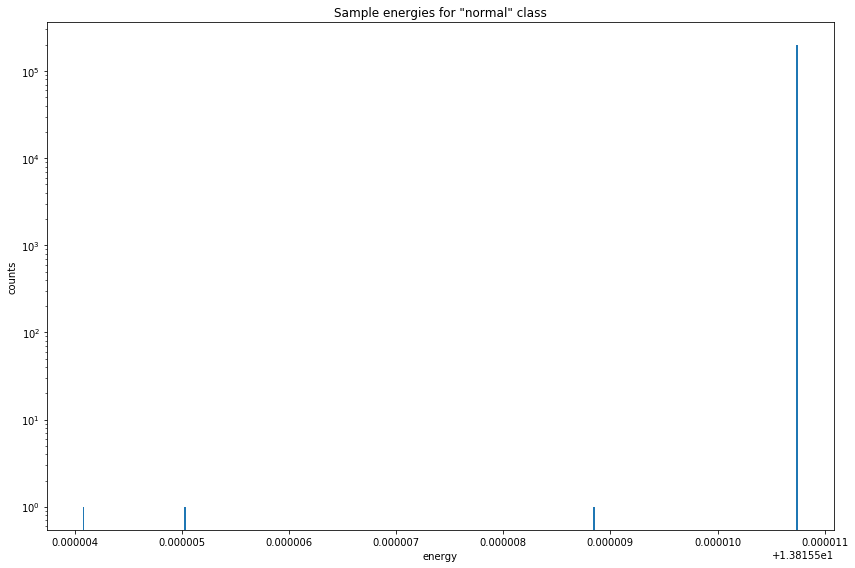

In [24]:
plt.hist(energies_normal, bins=hist_bins, log=True)

plt.title("Sample energies for \"normal\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-normalHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

- Energies from anomaly class

In [25]:
energies_anomaly = []

### from first batch until last batch (not processing last batch)
for i in range(0, len(anomaly_data)//batch_size - 1):
    start_idx = i * batch_size
      
    batch = anomaly_data[start_idx : start_idx+batch_size]

    print("running step:",i)
    
    energies_anomaly.append(vae.test_network(batch))
    
    
### TODO: process last batch

running step: 0
running step: 1
running step: 2
running step: 3
running step: 4
running step: 5
running step: 6
running step: 7
running step: 8
running step: 9
running step: 10
running step: 11
running step: 12
running step: 13
running step: 14
running step: 15
running step: 16
running step: 17
running step: 18
running step: 19
running step: 20
running step: 21
running step: 22
running step: 23
running step: 24
running step: 25
running step: 26
running step: 27
running step: 28
running step: 29
running step: 30
running step: 31
running step: 32
running step: 33
running step: 34
running step: 35
running step: 36
running step: 37
running step: 38
running step: 39
running step: 40
running step: 41
running step: 42
running step: 43
running step: 44
running step: 45


In [26]:
energies_anomaly = np.asarray(energies_anomaly)

In [27]:
energies_anomaly = energies_anomaly.ravel()

In [28]:
energies_anomaly.min()

13.81551

In [29]:
energies_anomaly.max()

13.815511

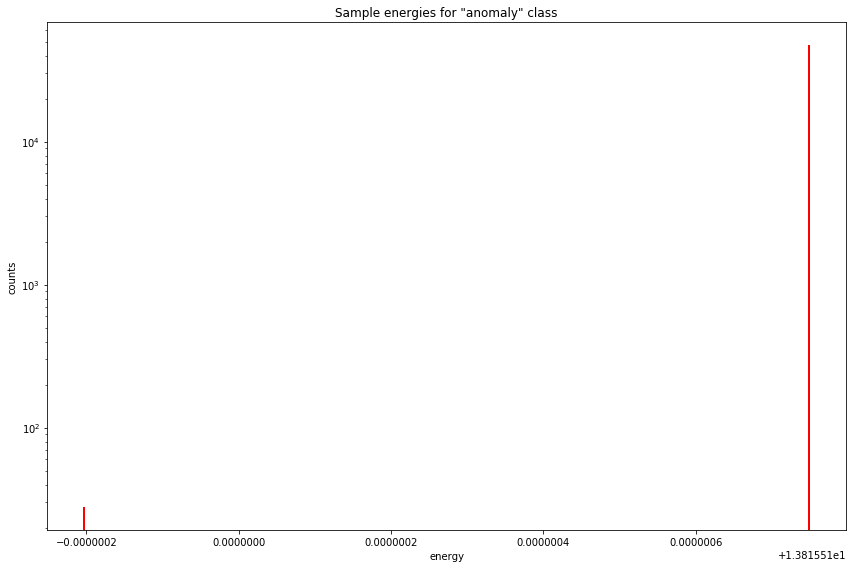

In [30]:
plt.hist(energies_anomaly, bins=hist_bins, color="red", log=True)

plt.title("Sample energies for \"anomaly\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-anomalyHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

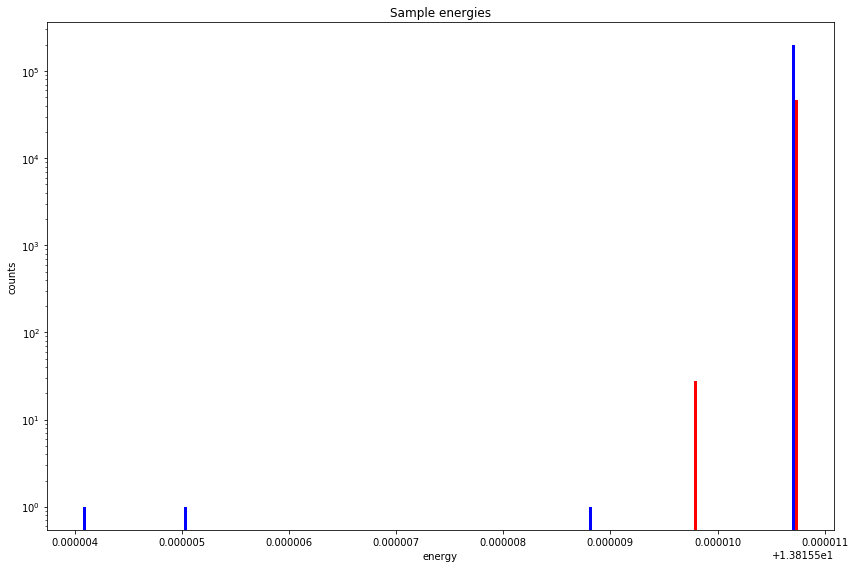

In [31]:
hist_bins = 120

plt.hist((energies_normal, energies_anomaly), 
         bins=hist_bins, 
         color=["blue", "red"], 
         histtype="bar", 
         label=["normal", "anomaly"], 
         rwidth=1.0,
         stacked=False,
         log=True)

plt.title("Sample energies")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-allHist_bins{}.png".format(hist_bins)
plt.savefig(filename)


### Find the threshold for classifying as anomaly: "top %20 of highest energy"

In [32]:
energies_all = np.concatenate((energies_normal, energies_anomaly), axis=0)

In [33]:
energies_all.shape

(243712,)

- Sort calculated energies descending

In [34]:
sorted_energies = np.sort(energies_all)[::-1]

In [35]:
sorted_energies

array([13.815511, 13.815511, 13.815511, ..., 13.815509, 13.815505,
       13.815504], dtype=float32)

- Top %20 percent is the first %20 part of it

In [36]:
threshold_index = int(np.floor(len(sorted_energies) * 0.2))

In [37]:
sorted_energies[:threshold_index]

array([13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
       13.815511], dtype=float32)

In [38]:
threshold = sorted_energies[threshold_index]

- Below this threshold, samples are classified as normal

In [39]:
threshold

13.815511

### Calculate metrics

- "Anomaly class is positive" (from paper)

|                   | anomaly | normal |   |   |
|-------------------|---------|--------|---|---|
| predicted anomaly | TP      | FP     |   |   |
| predicted normal  | FN      | TN     |   |   |
|                   |         |        |   |   |

In [40]:
tp = len(energies_anomaly[energies_anomaly > threshold])
fp = len(energies_normal[energies_normal > threshold])

tn = len(energies_normal[energies_normal < threshold])
fn = len(energies_anomaly[energies_anomaly < threshold])

In [41]:
precision = tp / (tp + fp)

ZeroDivisionError: division by zero

In [ ]:
precision

In [ ]:
recall = tp / (tp + fn)

In [ ]:
recall

In [ ]:
f1 = 2*tp / (2*tp + fp + fn)

In [ ]:
f1